In [1]:
import numpy as np
from scipy import stats, optimize
import matplotlib.pyplot as plt
np.random.seed(123)

$$\frac{\partial C}{\partial t} - \mathcal{D}\left( \frac{\partial^2 C}{\partial r^2} + \frac{2}{r}\frac{\partial C}{\partial r}\right) = 0$$

$$\gamma(t) = \frac{C(t,R)}{C(0,R)} = \frac{\alpha}{1 + \alpha} + 6 \alpha \sum\limits_{i=1}^\infty \frac{\exp \left(-\mathcal{D}\frac{q_n^2 t}{R^2}\right)}{9(\alpha + 1) + \alpha^2q_n^2}$$

$$\alpha = \frac{V_l}{V_s K_p}$$

$$\forall q_n \in \mathbb{R}^+_0 \, | \, \tan(q_n) = \frac{3 q_n}{3 + \alpha q_n^2} $$

In [2]:
class Solver:
    
    def __init__(self, alpha):
        self.alpha = alpha
        self.roots = {}
        
    def lhs(self, x):
        return np.tan(x)
    
    def rhs(self, x):
        return 3*x/(3 + self.alpha*x**2)

    def interval(self, n):
        return (-np.pi/2 + n*np.pi, np.pi/2 + n*np.pi)
    
    def objective(self, x):
        return (self.lhs(x) - self.rhs(x))**2

    def root(self, n):
        if n not in self.roots:
            result = optimize.minimize_scalar(
                self.objective,
                method="bounded",
                bounds=self.interval(n)
            )
            self.roots[n] = result.x
        return self.roots[n]
    
    def compute(self, n):
        solutions = []
        for i in range(n):
            solutions.append(self.root(i + 1))
        return np.array(solutions)

In [3]:
handler = Solver(3)

In [4]:
xlin = np.linspace(-4*np.pi, 10*np.pi, 5000)

In [5]:
xr = handler.compute(10)

In [6]:
xr

array([ 3.40560956,  6.43379729,  9.52821635, 12.64480217, 15.77103322,
       18.90226315, 22.03640253, 25.17238551, 28.30960007, 31.44768341])

In [7]:
lhs = handler.lhs(xlin)
q = np.where(np.diff(lhs) < 0)[0]
lhs[q] = np.nan

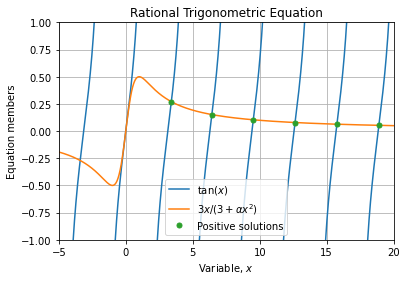

In [8]:
fig, axe = plt.subplots()
axe.plot(xlin, lhs, label=r"$\tan(x)$")
axe.plot(xlin, handler.rhs(xlin), label=r"$3 x / (3 + \alpha x^2)$")
axe.plot(xr, handler.rhs(xr), ".", markersize=10, label="Positive solutions")
axe.set_xlim([-5, 20])
axe.set_ylim([-1, 1])
axe.set_title("Rational Trigonometric Equation")
axe.set_xlabel(r"Variable, $x$")
axe.set_ylabel(r"Equation members")
axe.legend()
axe.grid()

In [9]:
class CrankDiffusion:
    
    def __init__(self, alpha=3, radius=1.9e-3, n=100):
        self.n = n
        self.alpha = alpha
        self.radius = radius
        self.objective = np.vectorize(self._objective, excluded='self')
    
    def alpha_prime(self, Kp):
        return self.alpha/Kp
    
    def solutions(self, Kp):
        return Solver(self.alpha_prime(Kp)).compute(self.n)
    
    def term(self, t, qn, Kp, D):
        return np.exp(-(D*t*qn**2)/(self.radius**2))/(9*(self.alpha_prime(Kp) + 1) + (self.alpha_prime(Kp)**2)*qn**2)
    
    def sum(self, t, Kp, D):
        return np.sum([self.term(t, qn, Kp, D) for qn in self.solutions(Kp)])
    
    def _objective(self, t, Kp, D):
        return self.alpha_prime(Kp)/(1 + self.alpha_prime(Kp)) + 6*self.alpha_prime(Kp)*self.sum(t, Kp, D)
        

In [10]:
S = CrankDiffusion()

In [11]:
tlin = np.logspace(0, 6, 100)

In [12]:
ratio = S.objective(tlin, 3.9, 2e-11)

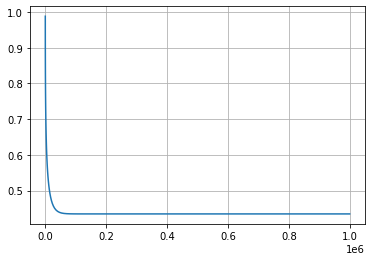

In [13]:
fig, axe = plt.subplots()
axe.plot(tlin, ratio)
axe.grid()

In [14]:
S.objective(0, 3.9, 2e-11)

array(0.99213723)

In [15]:
texp = np.logspace(0, 6, 20)
rexp = S.objective(texp, 3.9, 2e-11) + np.random.randn(texp.size)*0.005

In [16]:
parameters, covariance = optimize.curve_fit(S.objective, texp, rexp, (5, 1e-10))

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:16: RuntimeWarning: overflow encountered in exp
  app.launch_new_instance()


In [17]:
parameters, covariance

(array([3.82177515e+00, 2.12241711e-11]),
 array([[ 1.56607933e-03, -2.22707555e-14],
        [-2.22707555e-14,  5.97783602e-25]]))

In [18]:
rfit = S.objective(tlin, *parameters)

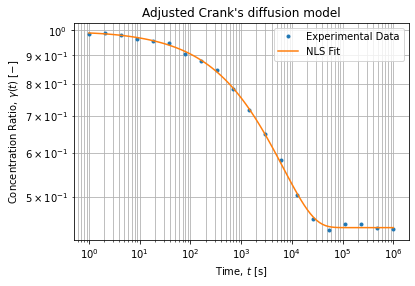

In [19]:
fig, axe = plt.subplots()
axe.loglog(texp, rexp, ".", label="Experimental Data")
axe.loglog(tlin, rfit, label="NLS Fit")
axe.set_title("Adjusted Crank's diffusion model")
axe.set_xlabel(r"Time, $t$ $[\mathrm{s}]$")
axe.set_ylabel(r"Concentration Ratio, $\gamma(t)$ $[-]$")
axe.legend()
axe.grid(which="both")

In [20]:
1.96*np.sqrt(1.57599053e-03)

0.07780954453052659

(1e-06, 0.1)

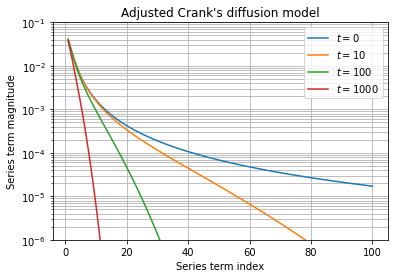

In [21]:
fig, axe = plt.subplots()
for t in [0, 10, 100, 1000]:
    terms = [S.term(t, s, 3.9, 2e-11) for s in S.solutions(3.9)]
    axe.semilogy(np.arange(len(terms)) + 1, terms, label=r"$t=%d$" % t)
axe.set_title("Adjusted Crank's diffusion model")
axe.set_xlabel("Series term index")
axe.set_ylabel("Series term magnitude")
axe.legend()
axe.grid(which="both")
axe.set_ylim([1e-6, 1e-1])

In [22]:
1e6/(60*60*24)

11.574074074074074